In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io

In [2]:
plt.ion()

In [3]:
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/FDR/groundtruth/'
allFiles = glob.glob(datadir + "*.xml")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    #print (file_)
    parsedXML = ET.parse( file_ )
    a=file_.split('/')
    a=a[len(a)-1]
    a=a.split('.xml')
    data = {}
    for k,el in enumerate(parsedXML.iterfind('./*')):
        data[k]=[a[0]+"_"+list(el.items()[0])[1]]
        for i in el.iterfind('*'):
            data[k].append(int(list(i.items()[0])[1]))
            for j in i.iterfind('*'):
                if (list(j.items()[0])[1]!=np.nan and list(j.items()[1])[1]!=np.nan):
                    data[k].append(int(list(j.items()[0])[1]))
                    data[k].append(int(list(j.items()[1])[1]))
    df = pd.DataFrame.from_dict(data, orient='index', columns = ['img_number', 'ID', 'lefteye_x', 'lefteye_y','righteye_x','righteye_y'])
    list_.append(df)
frame = pd.concat(list_,sort=False)
frame=frame.reset_index(drop=True)
frame=frame.drop([38074,38405],axis=0)
frame=frame.reset_index(drop=True)

In [4]:
a=np.where(frame['ID'].isnull(),0,1)
frame['human']=a
frame[frame['human']==1].count()

img_number    72289
ID            72289
lefteye_x     72289
lefteye_y     72289
righteye_x    72289
righteye_y    72289
human         72289
dtype: int64

In [13]:
frame.loc[171]

img_number    P2E_S1_C3.1_00000825
ID                              14
lefteye_x                      343
lefteye_y                      383
righteye_x                     437
righteye_y                     385
human                            1
Name: 171, dtype: object

In [12]:
def show_landmarks(image,id_, lx,ly,rx,ry):
    """Show image with landmarks"""
    if(lx!=None):
        plt.imshow(image)
        plt.scatter(lx, ly, s=10, marker='.', c='r')
        plt.scatter(rx, ry, s=10, marker='.', c='r')
        plt.pause(0.001)

In [109]:
plt.figure(figsize=(10,8))
show_landmarks(io.imread(os.path.join('images','{}.jpg'.format(frame.loc[1181]['img_number']))),int(frame.loc[1181]['lefteye_x']),int(frame.loc[1181]['lefteye_y']),int(frame.loc[1181]['righteye_x']),int(frame.loc[1181]['righteye_y']))
plt.show()

TypeError: show_landmarks() missing 1 required positional argument: 'ry'

<Figure size 720x576 with 0 Axes>

In [110]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df=dataframe
        self.img_dir=img_dir
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image=io.imread(os.path.join(self.img_dir,'{}.jpg'.format(frame.loc[idx]['img_number'])))
        if(self.df.loc[idx]['lefteye_x']!=None):
            lefteye=[int(self.df.loc[idx]['lefteye_x']),int(self.df.loc[idx]['lefteye_y'])]
            righteye=[int(self.df.loc[idx]['righteye_x']),int(self.df.loc[idx]['righteye_y'])]
            sample={'image':image,'id':int(self.df.loc[idx]['ID']),'lx':lefteye[0],'ly':lefteye[1],'rx':righteye[0],'ry':righteye[1] }
            if self.transform:
                sample=self.transform(sample)
            return sample
        else:
            return ({'image':image})

In [111]:
face_Dataset=FaceDataset(dataframe=frame,img_dir='images/')

<Figure size 432x288 with 0 Axes>

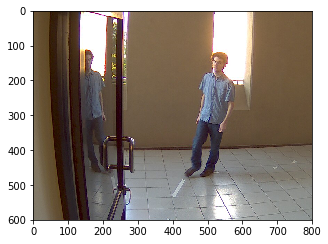

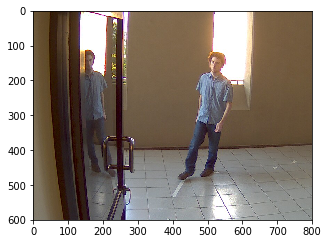

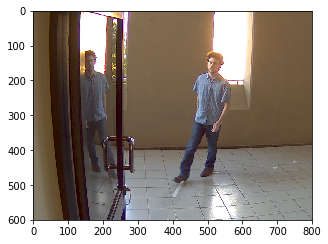

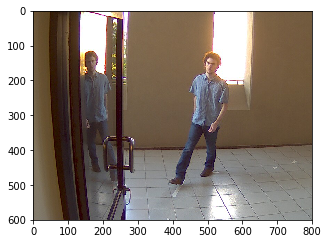

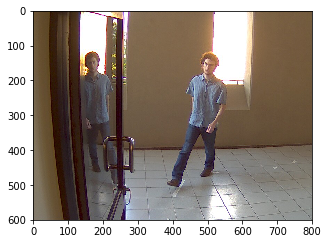

In [112]:
fig=plt.figure()
for i in range(150,155):
    sample=face_Dataset[i]
    plt.figure(figsize=(5,4))
    if(len(sample)>2):
        show_landmarks(sample['image'],sample['lx'],sample['ly'],sample['rx'],sample['ry'])
    else:
        plt.imshow(sample['image'])
plt.show()

In [114]:
class ToTensor(object):
    def __call__(self,sample):
        image=sample['image']
        id_=sample['id']
        lx=sample['lx']
        ly=sample['ly']
        rx=sample['rx']
        ry=sample['ry']
        image=image.transpose((2,0,1))
        return ({'image':torch.from_numpy(image),'id':id_,'lx':lx,'ly':ly,'rx':rx,'ry':ry})

In [115]:
transformed_dataset = FaceDataset(frame,img_dir='images/',transform=transforms.Compose([ToTensor()]))

In [117]:
for i in range(180,185):
    sample=transformed_dataset[i]
    print (i,sample['image'].size(),sample['id'],sample['lx'],sample['ly'],sample['rx'],sample['ry'])

180 torch.Size([3, 600, 800]) 2 406 176 429 176
181 torch.Size([3, 600, 800]) 2 405 180 429 180
182 torch.Size([3, 600, 800]) 2 404 186 430 186
183 torch.Size([3, 600, 800]) 2 404 192 430 192
184 torch.Size([3, 600, 800]) 2 404 200 430 198


In [104]:
dataloader = DataLoader(transformed_dataset, batch_size=100,shuffle=True)
